Scripts here are various rainfall calculations plotted against time. They only use data within the red rectangle area covering the Tiwi Islands plotted in the first cell block below.

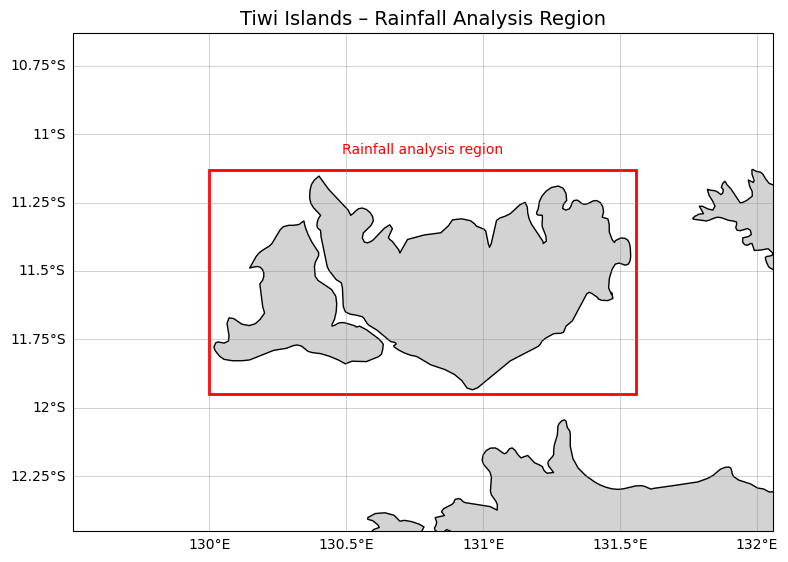

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle

# -------------------------------
# Region used in rainfall calculations
# -------------------------------
lat_min_exp = -11.95
lat_max_exp = -11.13
lon_min_exp = 130.0
lon_max_exp = 131.56

# Add a little padding so the box isn't tight to the map edge
pad = 0.5
extent = [
    lon_min_exp - pad,
    lon_max_exp + pad,
    lat_min_exp - pad,
    lat_max_exp + pad,
]

# -------------------------------
# Create map
# -------------------------------
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent(extent, crs=ccrs.PlateCarree())

# Coastlines and land
ax.add_feature(cfeature.LAND, facecolor="lightgrey")
ax.add_feature(cfeature.COASTLINE, linewidth=1.0)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color="gray", alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# -------------------------------
# Draw analysis box
# -------------------------------
analysis_box = Rectangle(
    (lon_min_exp, lat_min_exp),
    lon_max_exp - lon_min_exp,
    lat_max_exp - lat_min_exp,
    linewidth=2,
    edgecolor="red",
    facecolor="none",
    transform=ccrs.PlateCarree(),
)

ax.add_patch(analysis_box)

# Optional label
ax.text(
    0.5 * (lon_min_exp + lon_max_exp),
    lat_max_exp + 0.05,
    "Rainfall analysis region",
    color="red",
    fontsize=10,
    ha="center",
    va="bottom",
    transform=ccrs.PlateCarree(),
)

# -------------------------------
# Title
# -------------------------------
ax.set_title("Tiwi Islands – Rainfall Analysis Region", fontsize=14)

plt.tight_layout()
plt.show()


💾 Loading cached rainfall data from tiwi_rainfall_cache.npz


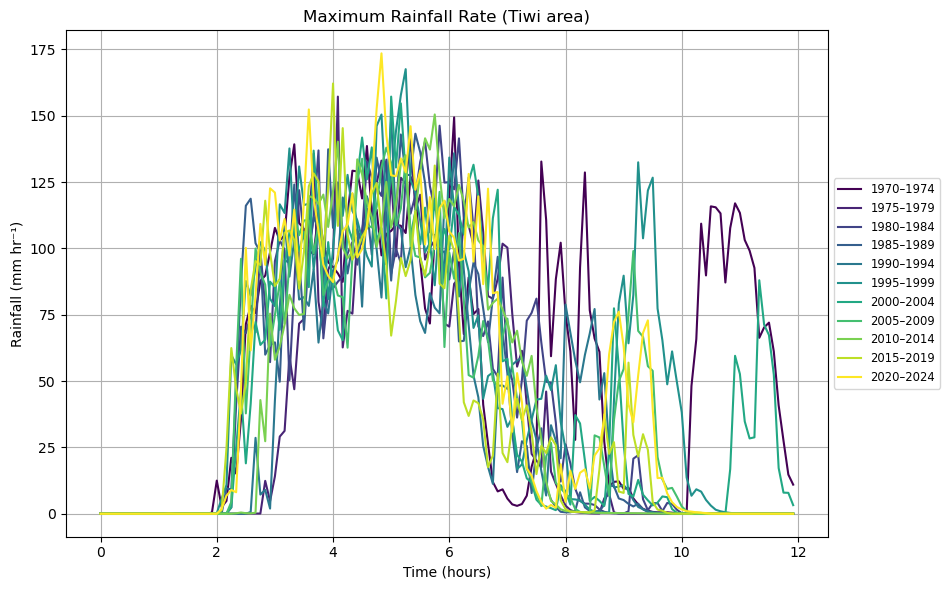

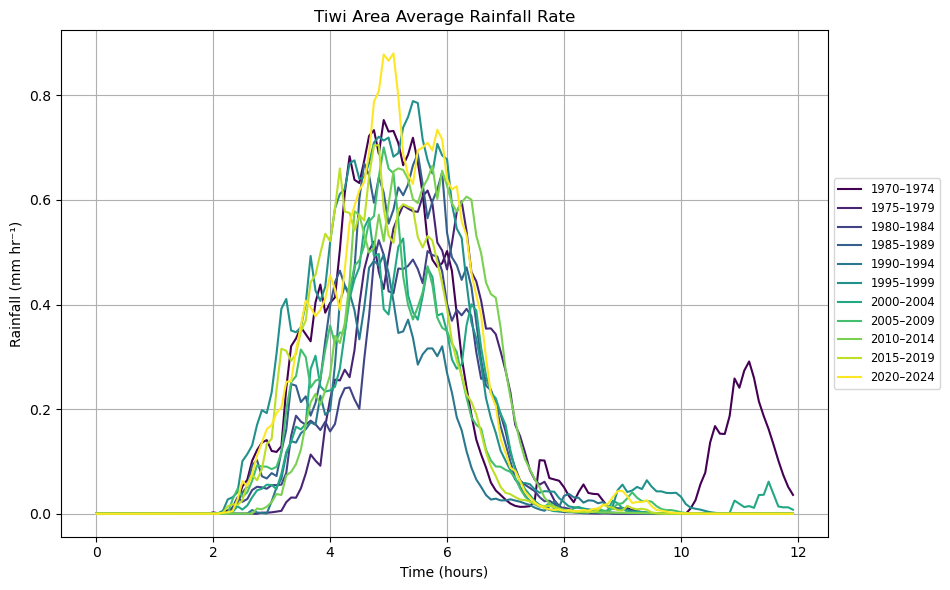

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# -------------------------------
# Settings
# -------------------------------
rain_var = "STASH_m01s04i203"  # Large-scale rainfall rate (kg m-2 s-1)
rain_cache_file = "tiwi_rainfall_cache.npz"

lat_min_exp = -11.95
lat_max_exp = -11.13
lon_min_exp = 130.0
lon_max_exp = 131.56

# -------------------------------
# File paths and year ranges
# -------------------------------
periods = [
    ("1970–1974", "/g/data/gx60/experiments/2025-06-11_tiwi/19701101T0000Z/Tiwi_12h_1970-1974_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1975–1979", "/g/data/gx60/experiments/2025-06-11_tiwi/19751101T0000Z/Tiwi_12h_1975-1979_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1980–1984", "/g/data/gx60/experiments/2025-06-11_tiwi/19801101T0000Z/Tiwi_12h_1980-1984_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1985–1989", "/g/data/gx60/experiments/2025-06-11_tiwi/19851101T0000Z/Tiwi_12h_1985-1989_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1990–1994", "/g/data/gx60/experiments/2025-06-11_tiwi/19901101T0000Z/Tiwi_12h_1990-1994_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1995–1999", "/g/data/gx60/experiments/2025-06-11_tiwi/19951101T0000Z/Tiwi_12h_1995-1999_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2000–2004", "/g/data/gx60/experiments/2025-06-11_tiwi/20001101T0000Z/Tiwi_12h_2000-2004_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2005–2009", "/g/data/gx60/experiments/2025-06-11_tiwi/20051101T0000Z/Tiwi_12h_2005-2009_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2010–2014", "/g/data/gx60/experiments/2025-06-11_tiwi/20101101T0000Z/Tiwi_12h_2010-2014_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2015–2019", "/g/data/gx60/experiments/2025-06-11_tiwi/20151101T0000Z/Tiwi_12h_2015-2019_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2020–2024", "/g/data/gx60/experiments/2025-06-11_tiwi/20201101T0000Z/Tiwi_12h_2020-2024_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
]

# -------------------------------
# Function to compute rainfall metrics
# -------------------------------
def compute_rainfall(file_path):
    ds = xr.open_dataset(file_path)

    # Subset the Tiwi region
    lat_idx = np.where((ds.grid_latitude_t >= lat_min_exp) & (ds.grid_latitude_t <= lat_max_exp))[0]
    lon_idx = np.where((ds.grid_longitude_t >= lon_min_exp) & (ds.grid_longitude_t <= lon_max_exp))[0]

    rain = ds[rain_var].isel(grid_latitude_t=lat_idx, grid_longitude_t=lon_idx)
    rain_mm_hr = rain * 3600.0  # kg m-2 s-1 → mm hr-1

    # Compute domain max and mean
    domain_max = rain_mm_hr.max(dim=["grid_latitude_t", "grid_longitude_t"])
    domain_mean = rain_mm_hr.mean(dim=["grid_latitude_t", "grid_longitude_t"])

    # Convert time to hours
    times_hr = (ds.t5min.values - ds.t5min.values[0]).astype("timedelta64[m]").astype(float) / 60.0
    ds.close()

    return domain_max.values, domain_mean.values, times_hr

# -------------------------------
# Load from cache or compute
# -------------------------------
if os.path.exists(rain_cache_file):
    print(f"💾 Loading cached rainfall data from {rain_cache_file}")
    data = np.load(rain_cache_file, allow_pickle=True)
    rain_max = data["rain_max"].item()
    rain_mean = data["rain_mean"].item()
    rain_times = data["rain_times"].item()
else:
    rain_max, rain_mean, rain_times = {}, {}, {}
    for i, (label, path) in enumerate(periods):
        print(f"🌧 Processing {label} ({i+1}/{len(periods)})...")
        start = time.time()
        try:
            rmax, rmean, times = compute_rainfall(path)
            rain_max[label] = rmax
            rain_mean[label] = rmean
            rain_times[label] = times
            print(f"   ✅ Done in {time.time() - start:.1f} s")
        except Exception as e:
            print(f"   ⚠️ Skipping {label}: {e}")
            continue

    np.savez(rain_cache_file, rain_max=rain_max, rain_mean=rain_mean, rain_times=rain_times)
    print(f"💾 Cached rainfall data saved to {rain_cache_file}")

# -------------------------------
# Plot function
# -------------------------------
def plot_metric(metric_dict, ylabel, title):
    plt.figure(figsize=(12,6))
    colors = plt.cm.viridis(np.linspace(0,1,len(periods)))
    for i, (label, _) in enumerate(periods):
        if label in metric_dict:
            plt.plot(rain_times[label], metric_dict[label], color=colors[i], label=label)
    plt.xlabel("Time (hours)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
    plt.tight_layout(rect=[0,0,0.8,1])
    plt.show()

# -------------------------------
# Plot rainfall metrics
# -------------------------------
plot_metric(rain_max, "Rainfall (mm hr⁻¹)", "Maximum Rainfall Rate (Tiwi area)")
plot_metric(rain_mean, "Rainfall (mm hr⁻¹)", "Tiwi Area Average Rainfall Rate")

💾 Loaded cached rainfall data from tiwi_rainfall_accum_cache.npz


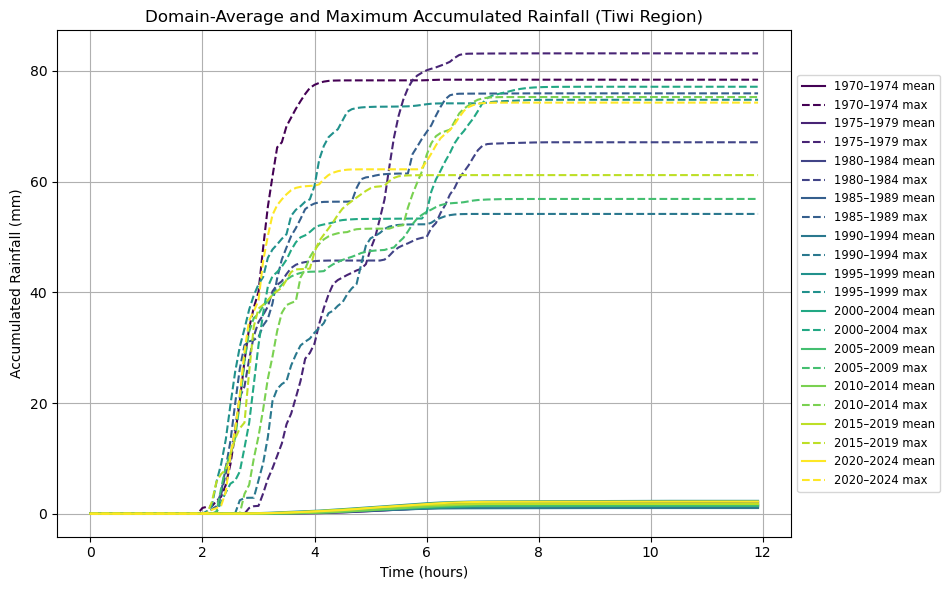

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# -------------------------------
# Settings
# -------------------------------
rain_var = "STASH_m01s04i203"
rain_cache_file = "tiwi_rainfall_accum_cache.npz"

lat_min_exp = -11.95
lat_max_exp = -11.13
lon_min_exp = 130.0
lon_max_exp = 131.56

periods = [
    ("1970–1974", "/g/data/gx60/experiments/2025-06-11_tiwi/19701101T0000Z/Tiwi_12h_1970-1974_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1975–1979", "/g/data/gx60/experiments/2025-06-11_tiwi/19751101T0000Z/Tiwi_12h_1975-1979_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1980–1984", "/g/data/gx60/experiments/2025-06-11_tiwi/19801101T0000Z/Tiwi_12h_1980-1984_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1985–1989", "/g/data/gx60/experiments/2025-06-11_tiwi/19851101T0000Z/Tiwi_12h_1985-1989_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1990–1994", "/g/data/gx60/experiments/2025-06-11_tiwi/19901101T0000Z/Tiwi_12h_1990-1994_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1995–1999", "/g/data/gx60/experiments/2025-06-11_tiwi/19951101T0000Z/Tiwi_12h_1995-1999_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2000–2004", "/g/data/gx60/experiments/2025-06-11_tiwi/20001101T0000Z/Tiwi_12h_2000-2004_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2005–2009", "/g/data/gx60/experiments/2025-06-11_tiwi/20051101T0000Z/Tiwi_12h_2005-2009_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2010–2014", "/g/data/gx60/experiments/2025-06-11_tiwi/20101101T0000Z/Tiwi_12h_2010-2014_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2015–2019", "/g/data/gx60/experiments/2025-06-11_tiwi/20151101T0000Z/Tiwi_12h_2015-2019_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2020–2024", "/g/data/gx60/experiments/2025-06-11_tiwi/20201101T0000Z/Tiwi_12h_2020-2024_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
]

# -------------------------------
# Function to compute mean and max accumulated rainfall
# -------------------------------
def compute_accumulated_rainfall(file_path):
    ds = xr.open_dataset(file_path)
    
    lat_idx = np.where((ds.grid_latitude_t >= lat_min_exp) & (ds.grid_latitude_t <= lat_max_exp))[0]
    lon_idx = np.where((ds.grid_longitude_t >= lon_min_exp) & (ds.grid_longitude_t <= lon_max_exp))[0]
    
    rain = ds[rain_var].isel(grid_latitude_t=lat_idx, grid_longitude_t=lon_idx)
    
    fill_value = rain.attrs.get("_FillValue")
    if fill_value is not None:
        rain = rain.where(rain != fill_value)
    
    t = ds.t5min.values
    dt = np.diff(t.astype("datetime64[s]")).astype(float)
    dt = np.append(dt, dt[-1])
    
    rain_mm = rain * dt[:, np.newaxis, np.newaxis]
    rain_accum = rain_mm.cumsum(dim="t5min")
    
    domain_mean = rain_accum.mean(dim=["grid_latitude_t", "grid_longitude_t"])
    domain_max  = rain_accum.max(dim=["grid_latitude_t", "grid_longitude_t"])
    
    ds.close()
    
    times_hr = (t - t[0]).astype("timedelta64[m]").astype(float) / 60.0
    return domain_mean.values, domain_max.values, times_hr

# -------------------------------
# Load cache if valid
# -------------------------------
def load_cache(cache_file):
    if not os.path.exists(cache_file):
        return None
    try:
        data = np.load(cache_file, allow_pickle=True)
        rain_mean = data["rain_mean"].item()
        rain_max = data["rain_max"].item()
        rain_times = data["rain_times"].item()
        return rain_mean, rain_max, rain_times
    except KeyError:
        # Cache exists but keys are wrong → recompute
        return None

cached = load_cache(rain_cache_file)
if cached is not None:
    rain_mean, rain_max, rain_times = cached
    print(f"💾 Loaded cached rainfall data from {rain_cache_file}")
else:
    rain_mean, rain_max, rain_times = {}, {}, {}
    for i, (label, path) in enumerate(periods):
        print(f"🌧 Processing {label} ({i+1}/{len(periods)})...")
        start = time.time()
        try:
            mean_accum, max_accum, times = compute_accumulated_rainfall(path)
            rain_mean[label] = mean_accum
            rain_max[label] = max_accum
            rain_times[label] = times
            print(f"   ✅ Done in {time.time() - start:.1f} s")
        except Exception as e:
            print(f"   ⚠️ Skipping {label}: {e}")
            continue
    np.savez(rain_cache_file, rain_mean=rain_mean, rain_max=rain_max, rain_times=rain_times)
    print(f"💾 Cached rainfall data saved to {rain_cache_file}")

# -------------------------------
# Plot both mean and max with matching colors
# -------------------------------
plt.figure(figsize=(12,6))
colors = plt.cm.viridis(np.linspace(0,1,len(periods)))

for i, (label, _) in enumerate(periods):
    color = colors[i]
    if label in rain_mean:
        plt.plot(rain_times[label], rain_mean[label], color=color, linestyle="-", label=f"{label} mean")
        plt.plot(rain_times[label], rain_max[label], color=color, linestyle="--", label=f"{label} max")

plt.xlabel("Time (hours)")
plt.ylabel("Accumulated Rainfall (mm)")
plt.title("Domain-Average and Maximum Accumulated Rainfall (Tiwi Region)")
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.tight_layout(rect=[0,0,0.8,1])
plt.show()

💾 Loaded cached data from tiwi_rainfall_mean_cache.npz


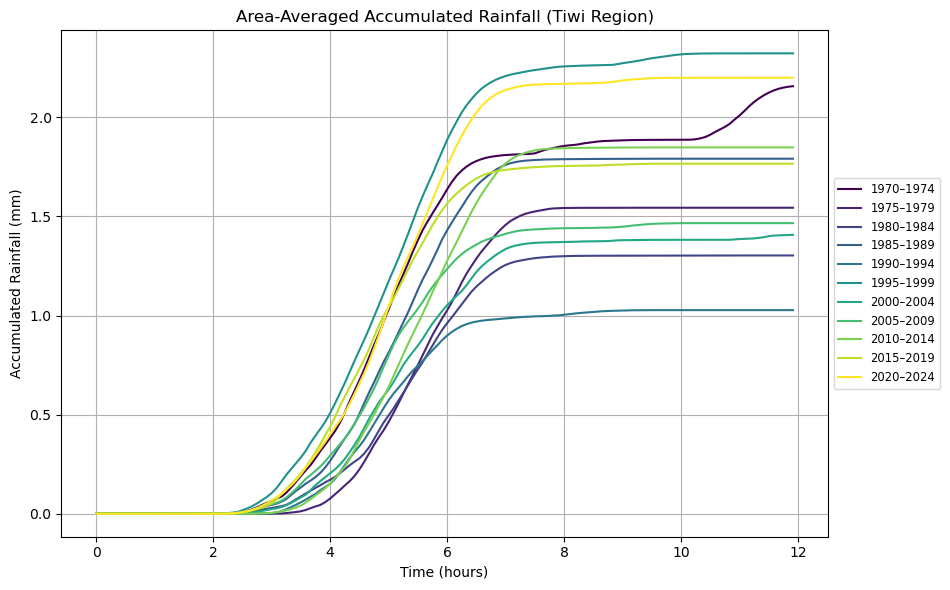

In [4]:
# Tiwi Islands encompassing rectangular area-averaged accumulated rainfall.
#
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# -------------------------------
# Settings
# -------------------------------
rain_var = "STASH_m01s04i203"
rain_cache_file = "tiwi_rainfall_mean_cache.npz"

lat_min_exp = -11.95
lat_max_exp = -11.13
lon_min_exp = 130.0
lon_max_exp = 131.56

periods = [
    ("1970–1974", "/g/data/gx60/experiments/2025-06-11_tiwi/19701101T0000Z/Tiwi_12h_1970-1974_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1975–1979", "/g/data/gx60/experiments/2025-06-11_tiwi/19751101T0000Z/Tiwi_12h_1975-1979_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1980–1984", "/g/data/gx60/experiments/2025-06-11_tiwi/19801101T0000Z/Tiwi_12h_1980-1984_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1985–1989", "/g/data/gx60/experiments/2025-06-11_tiwi/19851101T0000Z/Tiwi_12h_1985-1989_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1990–1994", "/g/data/gx60/experiments/2025-06-11_tiwi/19901101T0000Z/Tiwi_12h_1990-1994_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1995–1999", "/g/data/gx60/experiments/2025-06-11_tiwi/19951101T0000Z/Tiwi_12h_1995-1999_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2000–2004", "/g/data/gx60/experiments/2025-06-11_tiwi/20001101T0000Z/Tiwi_12h_2000-2004_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2005–2009", "/g/data/gx60/experiments/2025-06-11_tiwi/20051101T0000Z/Tiwi_12h_2005-2009_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2010–2014", "/g/data/gx60/experiments/2025-06-11_tiwi/20101101T0000Z/Tiwi_12h_2010-2014_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2015–2019", "/g/data/gx60/experiments/2025-06-11_tiwi/20151101T0000Z/Tiwi_12h_2015-2019_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2020–2024", "/g/data/gx60/experiments/2025-06-11_tiwi/20201101T0000Z/Tiwi_12h_2020-2024_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
]

# -------------------------------
# Function to compute area-averaged accumulated rainfall
# -------------------------------
def compute_area_mean_rainfall(file_path):
    ds = xr.open_dataset(file_path)
    
    lat_idx = np.where((ds.grid_latitude_t >= lat_min_exp) & (ds.grid_latitude_t <= lat_max_exp))[0]
    lon_idx = np.where((ds.grid_longitude_t >= lon_min_exp) & (ds.grid_longitude_t <= lon_max_exp))[0]
    
    rain = ds[rain_var].isel(grid_latitude_t=lat_idx, grid_longitude_t=lon_idx)
    
    fill_value = rain.attrs.get("_FillValue")
    if fill_value is not None:
        rain = rain.where(rain != fill_value)
    
    t = ds.t5min.values
    dt = np.diff(t.astype("datetime64[s]")).astype(float)
    dt = np.append(dt, dt[-1])
    
    rain_mm = rain * dt[:, np.newaxis, np.newaxis]
    rain_accum = rain_mm.cumsum(dim="t5min")
    
    domain_mean = rain_accum.mean(dim=["grid_latitude_t", "grid_longitude_t"])
    
    ds.close()
    times_hr = (t - t[0]).astype("timedelta64[m]").astype(float) / 60.0
    return domain_mean.values, times_hr

# -------------------------------
# Load or compute cache
# -------------------------------
if os.path.exists(rain_cache_file):
    try:
        data = np.load(rain_cache_file, allow_pickle=True)
        rain_mean = data["rain_mean"].item()
        rain_times = data["rain_times"].item()
        print(f"💾 Loaded cached data from {rain_cache_file}")
    except KeyError:
        rain_mean, rain_times = {}, {}
else:
    rain_mean, rain_times = {}, {}

if not rain_mean:  # empty → recompute
    for i, (label, path) in enumerate(periods):
        print(f"🌧 Processing {label} ({i+1}/{len(periods)})...")
        start = time.time()
        try:
            mean_accum, times = compute_area_mean_rainfall(path)
            rain_mean[label] = mean_accum
            rain_times[label] = times
            print(f"   ✅ Done in {time.time() - start:.1f} s")
        except Exception as e:
            print(f"   ⚠️ Skipping {label}: {e}")
            continue
    np.savez(rain_cache_file, rain_mean=rain_mean, rain_times=rain_times)
    print(f"💾 Cached rainfall data saved to {rain_cache_file}")

# -------------------------------
# Plot area-averaged accumulated rainfall
# -------------------------------
plt.figure(figsize=(12,6))
colors = plt.cm.viridis(np.linspace(0,1,len(periods)))

for i, (label, _) in enumerate(periods):
    if label in rain_mean:
        plt.plot(rain_times[label], rain_mean[label], color=colors[i], label=label)

plt.xlabel("Time (hours)")
plt.ylabel("Accumulated Rainfall (mm)")
plt.title("Area-Averaged Accumulated Rainfall (Tiwi Region)")
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.tight_layout(rect=[0,0,0.8,1])
plt.show()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.12/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


💾 Loaded cached data from tiwi_rainfall_landmean_cache.npz


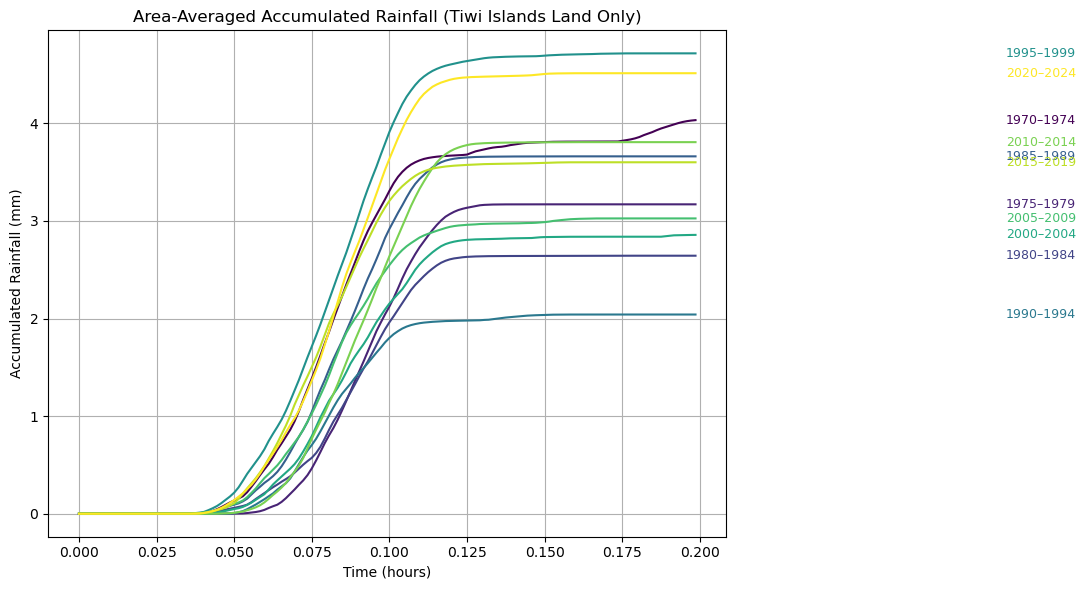

In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# -------------------------------
# Settings
# -------------------------------
rain_var = "STASH_m01s04i203"       # Large-scale rainfall rate
land_var = "STASH_m01s00i030"       # Land mask (1=land, 0=sea)
rain_cache_file = "tiwi_rainfall_landmean_cache.npz"

lat_min_exp = -11.95
lat_max_exp = -11.13
lon_min_exp = 130.0
lon_max_exp = 131.56

periods = [
    ("1970–1974", "/g/data/gx60/experiments/2025-06-11_tiwi/19701101T0000Z/Tiwi_12h_1970-1974_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1975–1979", "/g/data/gx60/experiments/2025-06-11_tiwi/19751101T0000Z/Tiwi_12h_1975-1979_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1980–1984", "/g/data/gx60/experiments/2025-06-11_tiwi/19801101T0000Z/Tiwi_12h_1980-1984_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1985–1989", "/g/data/gx60/experiments/2025-06-11_tiwi/19851101T0000Z/Tiwi_12h_1985-1989_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1990–1994", "/g/data/gx60/experiments/2025-06-11_tiwi/19901101T0000Z/Tiwi_12h_1990-1994_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1995–1999", "/g/data/gx60/experiments/2025-06-11_tiwi/19951101T0000Z/Tiwi_12h_1995-1999_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2000–2004", "/g/data/gx60/experiments/2025-06-11_tiwi/20001101T0000Z/Tiwi_12h_2000-2004_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2005–2009", "/g/data/gx60/experiments/2025-06-11_tiwi/20051101T0000Z/Tiwi_12h_2005-2009_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2010–2014", "/g/data/gx60/experiments/2025-06-11_tiwi/20101101T0000Z/Tiwi_12h_2010-2014_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2015–2019", "/g/data/gx60/experiments/2025-06-11_tiwi/20151101T0000Z/Tiwi_12h_2015-2019_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2020–2024", "/g/data/gx60/experiments/2025-06-11_tiwi/20201101T0000Z/Tiwi_12h_2020-2024_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
]

# -------------------------------
# Load land mask once (from first period)
# -------------------------------
land_ds = xr.open_dataset(periods[0][1])
lat_idx = np.where((land_ds.grid_latitude_t >= lat_min_exp) & (land_ds.grid_latitude_t <= lat_max_exp))[0]
lon_idx = np.where((land_ds.grid_longitude_t >= lon_min_exp) & (land_ds.grid_longitude_t <= lon_max_exp))[0]
land_mask = land_ds[land_var].isel(grid_latitude_t=lat_idx, grid_longitude_t=lon_idx)
land_mask = land_mask.astype(bool)   # convert 1/0 → True/False
land_ds.close()

# -------------------------------
# Function to compute area-averaged accumulated rainfall over land
# -------------------------------
def compute_land_mean_rainfall(file_path, land_mask):
    ds = xr.open_dataset(file_path)
    
    rain = ds[rain_var].isel(grid_latitude_t=lat_idx, grid_longitude_t=lon_idx)
    
    # Mask fill values
    fill_value = rain.attrs.get("_FillValue")
    if fill_value is not None:
        rain = rain.where(rain != fill_value)
    
    # Multiply by dt to get accumulation (s → mm)
    t = ds.t5min.values
    dt = np.diff(t.astype("datetime64[s]")).astype(float)
    dt = np.append(dt, dt[-1])
    
    rain_mm = rain * dt[:, np.newaxis, np.newaxis]
    rain_accum = rain_mm.cumsum(dim="t5min")
    
    # Apply land mask
    rain_land = rain_accum.where(land_mask)
    
    # Area average over land only
    domain_mean = rain_land.mean(dim=["grid_latitude_t", "grid_longitude_t"])
    
    ds.close()
    times_hr = (t - t[0]).astype("timedelta64[m]").astype(float) / 3600.0
    return domain_mean.values, times_hr

# -------------------------------
# Load or compute cache
# -------------------------------
if os.path.exists(rain_cache_file):
    try:
        data = np.load(rain_cache_file, allow_pickle=True)
        rain_mean = data["rain_mean"].item()
        rain_times = data["rain_times"].item()
        print(f"💾 Loaded cached data from {rain_cache_file}")
    except KeyError:
        rain_mean, rain_times = {}, {}
else:
    rain_mean, rain_times = {}, {}

if not rain_mean:
    for i, (label, path) in enumerate(periods):
        print(f"🌧 Processing {label} ({i+1}/{len(periods)})...")
        start = time.time()
        try:
            mean_accum, times = compute_land_mean_rainfall(path, land_mask)
            rain_mean[label] = mean_accum
            rain_times[label] = times
            print(f"   ✅ Done in {time.time() - start:.1f} s")
        except Exception as e:
            print(f"   ⚠️ Skipping {label}: {e}")
            continue
    np.savez(rain_cache_file, rain_mean=rain_mean, rain_times=rain_times)
    print(f"💾 Cached rainfall data saved to {rain_cache_file}")

# -------------------------------
# Plot area-averaged accumulated rainfall over land with labels at line ends
# -------------------------------
plt.figure(figsize=(12,6))
colors = plt.cm.viridis(np.linspace(0,1,len(periods)))

for i, (label, _) in enumerate(periods):
    if label in rain_mean:
        y = rain_mean[label]
        x = rain_times[label]
        plt.plot(x, y, color=colors[i])
        # Add label at the end of the line
        plt.text(x[-1]+0.1, y[-1], label, color=colors[i], fontsize=9, va='center')

plt.xlabel("Time (hours)")
plt.ylabel("Accumulated Rainfall (mm)")
plt.title("Area-Averaged Accumulated Rainfall (Tiwi Islands Land Only)")
plt.grid(True)
plt.tight_layout()
plt.show()

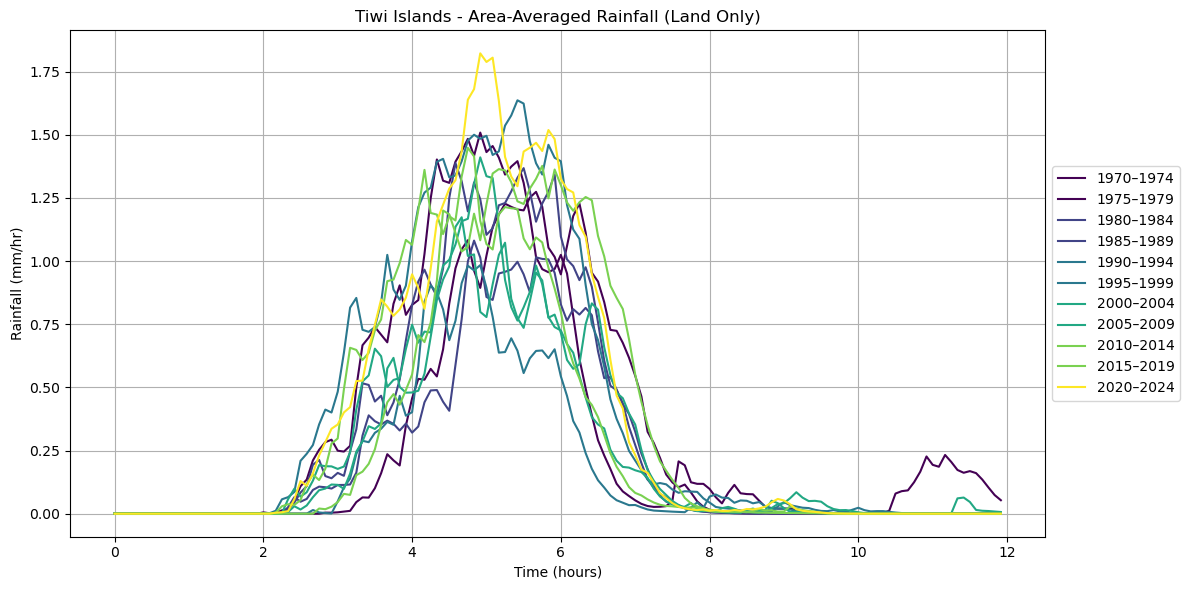

In [7]:
# The method in this block should be checked carefully for potential errors! It attempts to plot the average rainfall over the islands only.
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Settings
# -------------------------------
rain_var = "STASH_m01s04i203"
land_var = "STASH_m01s00i030"

lat_min_exp = -11.95
lat_max_exp = -11.13
lon_min_exp = 130.0
lon_max_exp = 131.56

# File paths and periods
periods = [
    ("1970–1974", "/g/data/gx60/experiments/2025-06-11_tiwi/19701101T0000Z/Tiwi_12h_1970-1974_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1975–1979", "/g/data/gx60/experiments/2025-06-11_tiwi/19751101T0000Z/Tiwi_12h_1975-1979_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1980–1984", "/g/data/gx60/experiments/2025-06-11_tiwi/19801101T0000Z/Tiwi_12h_1980-1984_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1985–1989", "/g/data/gx60/experiments/2025-06-11_tiwi/19851101T0000Z/Tiwi_12h_1985-1989_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1990–1994", "/g/data/gx60/experiments/2025-06-11_tiwi/19901101T0000Z/Tiwi_12h_1990-1994_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1995–1999", "/g/data/gx60/experiments/2025-06-11_tiwi/19951101T0000Z/Tiwi_12h_1995-1999_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2000–2004", "/g/data/gx60/experiments/2025-06-11_tiwi/20001101T0000Z/Tiwi_12h_2000-2004_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2005–2009", "/g/data/gx60/experiments/2025-06-11_tiwi/20051101T0000Z/Tiwi_12h_2005-2009_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2010–2014", "/g/data/gx60/experiments/2025-06-11_tiwi/20101101T0000Z/Tiwi_12h_2010-2014_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2015–2019", "/g/data/gx60/experiments/2025-06-11_tiwi/20151101T0000Z/Tiwi_12h_2015-2019_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2020–2024", "/g/data/gx60/experiments/2025-06-11_tiwi/20201101T0000Z/Tiwi_12h_2020-2024_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
]

# -------------------------------
# Assign same colors per decade
# -------------------------------
def get_decade(label):
    start_year = int(label.split('–')[0])
    return (start_year // 10) * 10

decades = sorted({get_decade(label) for label, _ in periods})
colors = plt.cm.viridis(np.linspace(0,1,len(decades)))
decade_color_map = {decade: colors[i] for i, decade in enumerate(decades)}

# -------------------------------
# Plot each period
# -------------------------------
plt.figure(figsize=(12,6))

for label, path in periods:
    try:
        ds = xr.open_dataset(path)
        
        # Subset Tiwi region
        lat_idx = np.where((ds.grid_latitude_t >= lat_min_exp) & (ds.grid_latitude_t <= lat_max_exp))[0]
        lon_idx = np.where((ds.grid_longitude_t >= lon_min_exp) & (ds.grid_longitude_t <= lon_max_exp))[0]
        
        rain = ds[rain_var].isel(grid_latitude_t=lat_idx, grid_longitude_t=lon_idx)
        land_mask = ds[land_var].isel(grid_latitude_t=lat_idx, grid_longitude_t=lon_idx).astype(bool)
        
        rain_land = rain.where(land_mask) * 3600.0  # Convert to mm/hr
        rain_mean = rain_land.mean(dim=["grid_latitude_t","grid_longitude_t"])
        
        # Time in hours
        times_hr = (ds.t5min.values - ds.t5min.values[0]).astype("timedelta64[m]").astype(float)/60.0
        ds.close()
        
        # Plot
        decade = get_decade(label)
        plt.plot(times_hr, rain_mean, color=decade_color_map[decade], label=label)
        
    except Exception as e:
        print(f"⚠️ Skipping {label}: {e}")
        continue

plt.xlabel("Time (hours)")
plt.ylabel("Rainfall (mm/hr)")
plt.title("Tiwi Islands - Area-Averaged Rainfall (Land Only)")
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.tight_layout()
plt.show()